In [1]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
sns.set(style="whitegrid")

## Forward Simulation

Parameters:

In [3]:
alpha = 0.9
beta = 0.2
lambda_p = [1,5]
gamma = 0.1

Big gamma matrix:

In [4]:
big_gamma = np.array([
    [1- gamma, 0, gamma], 
    [0, 1-gamma, gamma], 
    [beta/2, beta/2, 1- beta]
    ])

Simulation function

In [5]:
def sim(n,T):
    C = [None]*T
    C[0] = 2
    C_trans = {(1,0,0): 0, (0,1,0): 1, (0,0,1): 2} 

    for i in range(1,T):
        draw = np.random.multinomial(1, big_gamma[C[i-1], :], 1)
        C[i] = C_trans[tuple(draw[0])]

    Z = np.empty([n, T])

    probs = {0: 1-alpha, 1: alpha, 2: 0.5}
    
    Zs = [np.random.binomial(1, p = probs[c], size = n) for c in C]
    Z_flat = np.array(Zs).flat

    Xs = np.reshape([np.random.poisson(1+4*z) for z in Z_flat], newshape=(T, n))

    return [C, Zs, Xs]


## Visualizing

In [6]:
C, Z, X = sim(10,100)

In [7]:
color = {0:'red', 1:'green', 2: 'blue'}
C_color = [color[c] for c in C]
C_color

['blue',
 'red',
 'blue',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'blue',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'blue',
 'blue',
 'blue',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'blue',
 'green',
 'green',
 'green',
 'green',
 'blue',
 'blue',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'red',
 'red',
 'red',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'red',
 'red']

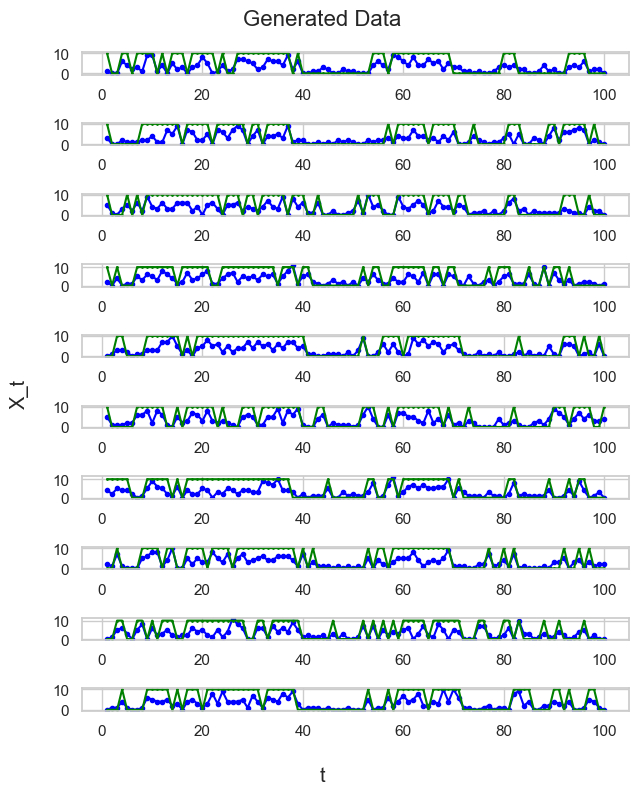

In [8]:
fig, axs = plt.subplots(10, 1, figsize= (6.5, 8))
x_plot = list(range(1,100+1))

for i in range(10):
    y_plot = X[:, i] 
    axs[i].plot(x_plot, y_plot, marker='o', markersize=3, color='blue')
    y_plot_z = [Z[0][i]*10]
    for j in range(1,100):
        y_plot_z.append(Z[j][i]*10)
    axs[i].plot(x_plot, y_plot_z, marker='o', markersize=1, color = 'green')
    #axs[i].text(1.05, 0.5, f'{i + 1}', fontsize=12, rotation=270)

fig.suptitle('Generated Data', fontsize=16)
fig.supxlabel('t')
fig.supylabel('X_t')

plt.tight_layout()
plt.show()


In [10]:
X_avg = [None]*100

for i in range(100):
    X_avg[i] = np.mean(X[i,:])

Text(0.5, 1.0, 'Average')

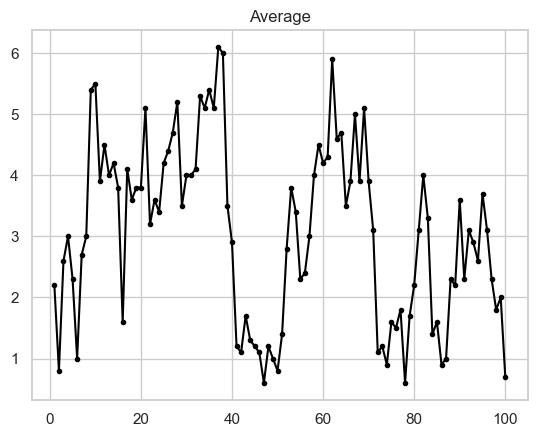

In [11]:
plt.plot(x_plot, X_avg, marker='o', markersize=3, color='black')
plt.title('Average')

## Multinomial logistic regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

Simulate lots of data

In [24]:
n1 = 1000
n2 = 10
T = 100

np.random.seed(42)

C, Z, X = np.empty(shape=(n1,T)), np.empty(shape=(n1,T,n2)), np.empty(shape=(n1, T, n2))

for i in range(n1):
    C[i], Z[i], X[i] = sim(10,100)


In [25]:
X_reg = X.reshape((1000, 100*10))

In [26]:
lr = LogisticRegression(max_iter=5000)
lr.fit(X_reg, C[:,50])

LogisticRegression(max_iter=5000)

Prediction accuracy

In [27]:
np.random.seed(80)
n1 = 1000

C_test, Z_test, X_test = np.empty(shape=(n1,T)), np.empty(shape=(n1,T,n2)), np.empty(shape=(n1, T, n2))

for i in range(n1):
    C_test[i], Z_test[i], X_test[i] = sim(10,100)

X_reg_test = X_test.reshape((1000, 100*10))

np.mean(lr.predict(X_reg_test) == C_test[:,50])


0.681

In [56]:
lr.coef_[]

array([[ 0.0778078 ,  0.07268664,  0.02987507, ...,  0.01279473,
        -0.01609889,  0.00337594],
       [-0.07653407, -0.16143527, -0.04559855, ..., -0.06138521,
        -0.07697275,  0.00546649],
       [-0.00127373,  0.08874864,  0.01572349, ...,  0.04859048,
         0.09307165, -0.00884242]])

In [37]:
print(np.mean(lr.coef_[0]), np.mean(lr.coef_[1]), np.mean(lr.coef_[2]))

-0.0008282251543576933 -0.00016048706693718896 0.0009887122212949874


Predict from only certain X's

In [28]:
new_x_reg = X[:,49:52,:]
new_x_reg = new_x_reg.reshape((1000, 10*3))

In [29]:
lr2 = LogisticRegression(max_iter=5000)
lr2.fit(new_x_reg, C[:,50])
lr2.coef_

array([[ 2.14438864e-01, -9.29859258e-02, -1.74980823e-01,
         2.19750471e-05,  3.21008743e-01,  3.54319183e-02,
         2.25631133e-01,  1.51182526e-01,  3.54352944e-02,
         8.11301625e-02, -1.07591182e-01, -2.71691696e-01,
         1.53713659e-01,  2.90145442e-01,  1.71137614e-01,
        -7.95912885e-02, -2.20657468e-02, -1.16127324e-01,
        -2.75394171e-01,  1.97664271e-01, -1.48741681e-01,
        -2.26365023e-01,  1.48689927e-01, -1.70465046e-01,
         7.53085994e-02,  1.22512957e-01, -2.59882885e-01,
        -3.98045147e-01, -1.10715210e-01,  4.16533056e-01,
         5.35948895e-03, -4.69262472e-01, -3.47308736e-02,
        -2.06323192e-01,  1.79620757e-01, -3.87925811e-01,
         1.67223025e-01, -2.11704136e-01, -3.68125918e-01,
        -8.00342388e-02, -2.57348410e-01, -2.55383696e-02,
        -4.82311586e-01, -3.68093624e-01, -4.47758589e-01,
        -1.44645748e-01, -1.87168609e-01, -5.33277177e-01,
        -2.25359173e-01, -1.96005041e-01, -4.53321747e-0

Accuracy

In [30]:
np.random.seed(80)
n1 = 1000

C_test, Z_test, X_test = np.empty(shape=(n1,T)), np.empty(shape=(n1,T,n2)), np.empty(shape=(n1, T, n2))

for i in range(n1):
    C_test[i], Z_test[i], X_test[i] = sim(10,100)

X_reg_test = X_test[:,0:10,:]
X_reg_test = X_reg_test.reshape((1000, 10*10))

np.mean(lr2.predict(X_reg_test) == C_test[:,1])

0.54

Den bliver dårligere til at forudse...

# Inference